<a href="https://colab.research.google.com/github/anmol0720/Word-Embedding/blob/master/Word_Embeddings_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
! wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip'
! wget 'http://nlp.stanford.edu/data/glove.6B.zip'
! unzip glove.6B.zip

--2019-11-02 14:20:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84188 (82K) [application/x-httpd-php]
Saving to: ‘sentiment labelled sentences.zip.4’

sentiment labelled  100%[===================>]  82.21K  --.-KB/s    in 0.08s   

2019-11-02 14:20:05 (1023 KB/s) - ‘sentiment labelled sentences.zip.4’ saved [84188/84188]

--2019-11-02 14:20:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-11-02 14:20:07--  https://nlp.stanford.edu/data/glove.6B.zip
Conn

In [7]:
! unzip 'sentiment labelled sentences.zip'

Archive:  sentiment labelled sentences.zip
   creating: sentiment labelled sentences/
  inflating: sentiment labelled sentences/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/sentiment labelled sentences/
  inflating: __MACOSX/sentiment labelled sentences/._.DS_Store  
  inflating: sentiment labelled sentences/amazon_cells_labelled.txt  
  inflating: sentiment labelled sentences/imdb_labelled.txt  
  inflating: __MACOSX/sentiment labelled sentences/._imdb_labelled.txt  
  inflating: sentiment labelled sentences/readme.txt  
  inflating: __MACOSX/sentiment labelled sentences/._readme.txt  
  inflating: sentiment labelled sentences/yelp_labelled.txt  
  inflating: __MACOSX/._sentiment labelled sentences  


In [0]:
! mv /content/'sentiment labelled sentences'/ /content/data1

In [0]:
! mkdir data1/sentiment_analysis

In [44]:
! mv data data/sentiment_analysis

mv: cannot stat 'data': No such file or directory


In [0]:
! mv glove.6B.zip data1/glove.6B.zip

In [12]:
! ls

 data1		 'sentiment labelled sentences.zip'
 glove.6B.zip.1  'sentiment labelled sentences.zip.1'
 __MACOSX	 'sentiment labelled sentences.zip.2'
 sample_data	 'sentiment labelled sentences.zip.3'


In [13]:
import pandas as pd

filepath_dict = {'yelp':   'data1/yelp_labelled.txt',
                 'amazon': 'data1/amazon_cells_labelled.txt',
                 'imdb':   'data1/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.head())

                                            sentence  label source
0                           Wow... Loved this place.      1   yelp
1                                 Crust is not good.      0   yelp
2          Not tasty and the texture was just nasty.      0   yelp
3  Stopped by during the late May bank holiday of...      1   yelp
4  The selection on the menu was great and so wer...      1   yelp


In [0]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
sent=vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train


<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [16]:
print(sent.get_feature_names())

['00', '10', '100', '11', '12', '15', '1979', '20', '2007', '23', '30', '35', '40', '40min', '4ths', '5lb', '70', '90', '99', 'about', 'above', 'absolute', 'absolutely', 'accident', 'accommodations', 'accordingly', 'accountant', 'ache', 'acknowledged', 'across', 'actual', 'actually', 'added', 'affordable', 'after', 'afternoon', 'again', 'ago', 'ahead', 'airport', 'ala', 'albondigas', 'all', 'allergy', 'almonds', 'almost', 'alone', 'also', 'although', 'always', 'am', 'amazing', 'ambiance', 'ambience', 'amount', 'ample', 'an', 'and', 'angry', 'annoying', 'another', 'any', 'anything', 'anytime', 'anyway', 'anyways', 'apart', 'apologize', 'app', 'appalling', 'apparently', 'appealing', 'appetite', 'appetizer', 'appetizers', 'apple', 'are', 'area', 'aren', 'around', 'array', 'arrived', 'arrives', 'arriving', 'article', 'as', 'ask', 'asked', 'asking', 'assure', 'at', 'ate', 'atmosphere', 'atrocious', 'attached', 'attack', 'attention', 'attentive', 'attitudes', 'auju', 'authentic', 'average', 

In [17]:
print(X_test.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(solver= 'lbfgs')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


In [19]:
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression(solver= 'lbfgs')
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


In [20]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                25060     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Training Accuracy: 1.0000
Testing Accuracy:  0.7754


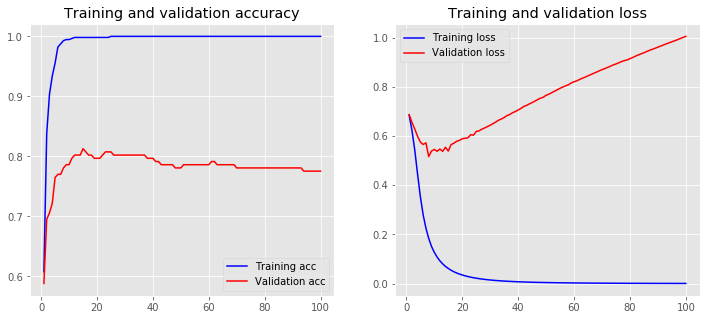

In [22]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [30]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[1])
print(X_train[1])
print(vocab_size)


I keep watching it over and over.  
[7, 310, 97, 8, 117, 3, 117]
2575


In [31]:
for word in ['the', 'all', 'me', 'you']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27
me: 89
you: 26


In [34]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
print(X_train[7, :])

[313   7 395   6  11   2  56  35   4   2  18  56 396   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [35]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim= vocab_size, 
                           output_dim= embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.6898


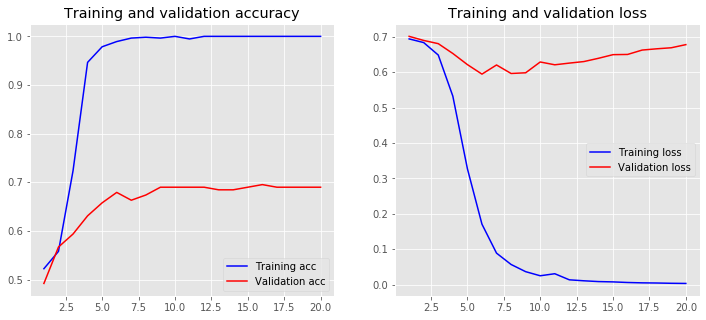

In [36]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________
Training Accuracy: 1.0000
Testing Accuracy:  0.8021


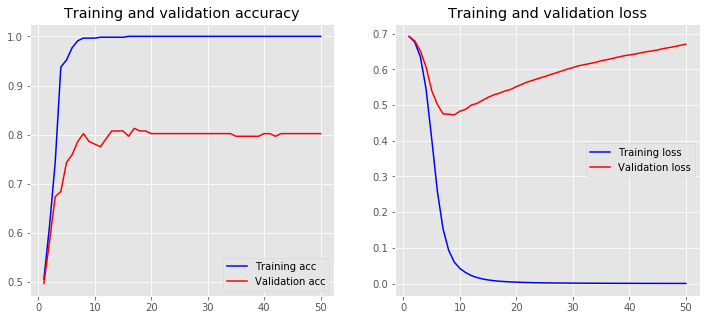

In [37]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [38]:
! ls

 data1		 'sentiment labelled sentences.zip'
 glove.6B.zip.1  'sentiment labelled sentences.zip.1'
 __MACOSX	 'sentiment labelled sentences.zip.2'
 sample_data	 'sentiment labelled sentences.zip.3'


In [46]:
! head -n 1 glove.6B.50d.txt | cut -c-50

the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.04445


In [0]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [56]:
! ls cd data1

ls: cannot access 'cd': No such file or directory
data1:
amazon_cells_labelled.txt  imdb_labelled.txt  sentiment_analysis
glove.6B.zip		   readme.txt	      yelp_labelled.txt


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 129,271
Trainable params: 521
Non-trainable params: 128,750
_________________________________________________________________
Training Accuracy: 0.7611
Testing Accuracy:  0.7487


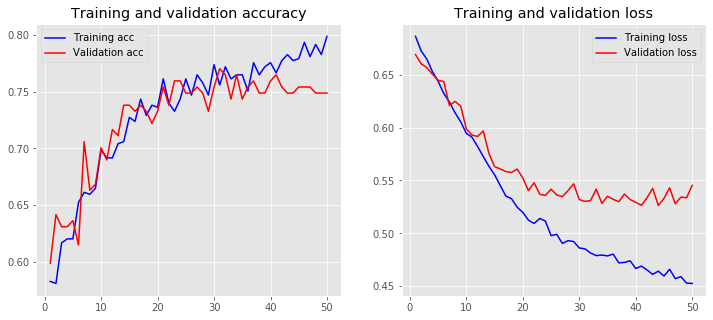

In [59]:
# pre-trained word embeddings
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
# trainable embeddings layer
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix], 
                           input_length=maxlen,
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [0]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
  
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)